In [ ]:
# default_exp rl.agents.replay_agents

# Replay Agents
> Replay Agents.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
import numpy as np
from tqdm import tqdm

In [ ]:
#export
class ABTestReplayer():
    '''
    A class to provide functionality for simulating the method on an A/B test.
    '''
    
    def __init__(self, n_visits, n_test_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1):
        
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name

        # number of runs to average over
        self.n_iterations = n_iterations

        
        # TODO: validate that n_test_visits <= n_visits
    
        self.n_test_visits = n_test_visits

        # number of visits to replay/simulate
        self.n_visits = n_visits

        # items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        # visitors in the historical reward_history (e.g., from ratings df)
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)
        
        self.is_testing = True
        self.best_item_id = None
        
    def reset(self):
        # number of times each item has been sampled (previously n_sampled)
        self.n_item_samples = np.zeros(self.n_items)
        
        # fraction of time each item has resulted in a reward (previously movie_clicks)
        self.n_item_rewards = np.zeros(self.n_items)
        
        self.is_testing = True
        self.best_item_idx = None
    
    def select_item(self):
        if self.is_testing:
            return np.random.randint(self.n_items)
        else:
            return self.best_item_idx
            
    def record_result(self, visit, item_idx, reward):
    
        self.n_item_samples[item_idx] += 1
        
        alpha = 1./self.n_item_samples[item_idx]

        self.n_item_rewards[item_idx] += alpha * (reward - self.n_item_rewards[item_idx])
        
        if (visit == self.n_test_visits - 1): # this was the last visit during the testing phase
            
            self.is_testing = False
            self.best_item_idx = np.argmax(self.n_item_rewards)

    def simulator(self):
    
        results = []

        for iteration in tqdm(range(0, self.n_iterations)):
        
            self.reset()
            
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in range(0, self.n_visits):
            
                found_match = False
                while not found_match:
                
                    # choose a random visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # select an item to offer the visitor
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]
                    
                    # if this interaction exists in the history, count it
                    reward = self.reward_history.query(
                        '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                    
                    found_match = reward.shape[0] > 0
                
                reward_value = reward.iloc[0]
                
                self.record_result(visit, item_idx, reward_value)
                
                # record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
                
                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['item_id'] = item_id
                result['visitor_id'] = visitor_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
                
                results.append(result)
        
        return results

In [ ]:
#export
class EpsilonGreedyReplayer():
    '''
    A class to provide functionality for simulating the replayer method on an epsilon-Greedy bandit algorithm.
    '''

    def __init__(self, epsilon, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1):
        
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name

        # number of runs to average over
        self.n_iterations = n_iterations
    
        # parameter to control exploration vs exploitation
        self.epsilon = epsilon

        # number of visits to replay/simulate
        self.n_visits = n_visits

        # items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        # visitors in the historical reward_history (e.g., from ratings df)
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)
        
        self.is_testing = True
        self.best_item_id = None
    
    def select_item(self):
        
        # decide to explore or exploit
        if np.random.uniform() < self.epsilon: # explore
            item_id = np.random.randint(self.n_items)
            
        else: # exploit
            item_id = np.argmax(self.n_item_rewards)
            
        return item_id
    
    def reset(self):
        # number of times each item has been sampled (previously n_sampled)
        self.n_item_samples = np.zeros(self.n_items)
        
        # fraction of time each item has resulted in a reward (previously movie_clicks)
        self.n_item_rewards = np.zeros(self.n_items)

    def record_result(self, visit, item_idx, reward):
    
        self.n_item_samples[item_idx] += 1
        
        alpha = 1./self.n_item_samples[item_idx]
        self.n_item_rewards[item_idx] += alpha * (reward - self.n_item_rewards[item_idx])

    
    def simulator(self):

        results = []

        for iteration in tqdm(range(0, self.n_iterations)):
        
            self.reset()
            
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in range(0, self.n_visits):
            
                found_match = False
                while not found_match:
                
                    # choose a random visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # select an item to offer the visitor
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]
                    
                    # if this interaction exists in the history, count it
                    reward = self.reward_history.query(
                        '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                    
                    found_match = reward.shape[0] > 0
                
                reward_value = reward.iloc[0]
                
                self.record_result(visit, item_idx, reward_value)
                
                # record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
                
                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['item_id'] = item_id
                result['visitor_id'] = visitor_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
                
                results.append(result)
        
        return results

In [ ]:
#export
class ThompsonSamplingReplayer():
    '''
    A class to provide functionality for simulating the replayer method on a Thompson Sampling bandit algorithm

    '''

    def __init__(self, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1):
        
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name

        # number of runs to average over
        self.n_iterations = n_iterations
    


        # number of visits to replay/simulate
        self.n_visits = n_visits

        # items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        # visitors in the historical reward_history (e.g., from ratings df)
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)
        
        self.is_testing = True
        self.best_item_id = None

    def reset(self):
        self.alphas = np.ones(self.n_items)
        self.betas = np.ones(self.n_items)

    def select_item(self):
    
        samples = [np.random.beta(a,b) for a,b in zip(self.alphas, self.betas)]
        
        return np.argmax(samples)

    def record_result(self, visit, item_idx, reward):
        
        # update value estimate
        if reward == 1:
            self.alphas[item_idx] += 1
        else:
            self.betas[item_idx] += 1



    def simulator(self):

        results = []

        for iteration in tqdm(range(0, self.n_iterations)):
        
            self.reset()
            
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in range(0, self.n_visits):
            
                found_match = False
                while not found_match:
                
                    # choose a random visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # select an item to offer the visitor
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]
                    
                    # if this interaction exists in the history, count it
                    reward = self.reward_history.query(
                        '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                    
                    found_match = reward.shape[0] > 0
                
                reward_value = reward.iloc[0]
                
                self.record_result(visit, item_idx, reward_value)
                
                # record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
                
                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['item_id'] = item_id
                result['visitor_id'] = visitor_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
                
                results.append(result)
        
        return results

In [ ]:
#export
class ReplaySimulator(object):
    '''
    A class to provide base functionality for simulating the replayer method for online algorithms.
    '''

    def __init__(self, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1, random_seed=1):

        np.random.seed(random_seed)
    
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name

        # number of visits to replay/simulate
        self.n_visits = n_visits
        
        # number of runs to average over
        self.n_iterations = n_iterations
    
        # items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        # visitors in the historical reward_history (e.g., from ratings df)
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)
        

    def reset(self):
        # number of times each item has been sampled (previously n_sampled)
        self.n_item_samples = np.zeros(self.n_items)
        
        # fraction of time each item has resulted in a reward (previously movie_clicks)
        self.n_item_rewards = np.zeros(self.n_items)
        
    
    def replay(self):
        
        results = []

        for iteration in tqdm(range(0, self.n_iterations)):
        
            self.reset()
            
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in range(0, self.n_visits):
            
                found_match = False
                while not found_match:
                
                    # choose a random visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # select an item to offer the visitor
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]
                    
                    # if this interaction exists in the history, count it
                    reward = self.reward_history.query(
                        '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                    
                    found_match = reward.shape[0] > 0
                
                reward_value = reward.iloc[0]
                
                self.record_result(visit, item_idx, reward_value)
                
                ## record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
                
                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['item_id'] = item_id
                result['visitor_id'] = visitor_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
                
                results.append(result)
        
        return results
        
    def select_item(self):
        return np.random.randint(self.n_items)
        
    def record_result(self, visit, item_idx, reward):
    
        self.n_item_samples[item_idx] += 1
        
        alpha = 1./self.n_item_samples[item_idx]
        self.n_item_rewards[item_idx] += alpha * (reward - self.n_item_rewards[item_idx])

In [ ]:
#export
class UCBSamplingReplayer():
    '''
    A class to provide functionality for simulating the replayer method on a Thompson Sampling bandit algorithm

    '''

    def __init__(self,ucb_c, n_visits, reward_history, item_col_name, visitor_col_name, reward_col_name, n_iterations=1):
        
        self.reward_history = reward_history
        self.item_col_name = item_col_name
        self.visitor_col_name = visitor_col_name
        self.reward_col_name = reward_col_name
        self.ucb_c = ucb_c

        # number of runs to average over
        self.n_iterations = n_iterations
    


        # number of visits to replay/simulate
        self.n_visits = n_visits

        # items under test
        self.items = self.reward_history[self.item_col_name].unique()
        self.n_items = len(self.items)
        
        # visitors in the historical reward_history (e.g., from ratings df)
        self.visitors = self.reward_history[self.visitor_col_name].unique()
        self.n_visitors = len(self.visitors)
        
        self.is_testing = True
        self.best_item_id = None

    def reset(self):
        self.Q = np.zeros(self.n_items) # q-value of actions
        self.N = np.zeros(self.n_items) + 0.0001 # action count
        self.timestep = 1


    def select_item(self):

        ln_timestep = np.log(np.full(self.n_items, self.timestep))
        confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)

        action = np.argmax(self.Q + confidence)
        self.timestep += 1
        
        return action

    def record_result(self, visit, item_idx, reward):
        
        # update value estimate
        self.N[item_idx] += 1 # increment action count
        self.Q[item_idx] += 1/self.N[item_idx] * (reward - self.Q[item_idx]) # inc. update rule


    def simulator(self):

        results = []

        for iteration in tqdm(range(0, self.n_iterations)):
        
            self.reset()
            
            total_rewards = 0
            fraction_relevant = np.zeros(self.n_visits)

            for visit in range(0, self.n_visits):
            
                found_match = False
                while not found_match:
                
                    # choose a random visitor
                    visitor_idx = np.random.randint(self.n_visitors)
                    visitor_id = self.visitors[visitor_idx]

                    # select an item to offer the visitor
                    item_idx = self.select_item()
                    item_id = self.items[item_idx]
                    
                    # if this interaction exists in the history, count it
                    reward = self.reward_history.query(
                        '{} == @item_id and {} == @visitor_id'.format(self.item_col_name, self.visitor_col_name))[self.reward_col_name]
                    
                    found_match = reward.shape[0] > 0
                
                reward_value = reward.iloc[0]
                
                self.record_result(visit, item_idx, reward_value)
                
                # record metrics
                total_rewards += reward_value
                fraction_relevant[visit] = total_rewards * 1. / (visit + 1)
                
                result = {}
                result['iteration'] = iteration
                result['visit'] = visit
                result['item_id'] = item_id
                result['visitor_id'] = visitor_id
                result['reward'] = reward_value
                result['total_reward'] = total_rewards
                result['fraction_relevant'] = total_rewards * 1. / (visit + 1)
                
                results.append(result)
        
        return results

In [ ]:
# !pip install -q -U kaggle
# !pip install --upgrade --force-reinstall --no-deps kaggle
# !mkdir ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d saurav9786/amazon-product-reviews
!unzip amazon-product-reviews.zip

     |████████████████████████████████| 58 kB 2.7 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=af09991cd9752149427a8c7425a45ec5996a6496469a41710e1d6a123ccd647e
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
 85% 93.0M/109M [00:00<00:00, 117MB/s]
100% 109M/109M [00:00<00:00, 115MB/s] 
Archive:  amazon-product-reviews.zip
  inflating: ratings_Electronics (1).csv  


In [ ]:
import pandas as pd

header_list = ["User_ID", "Product_ID", "Rating", "Time_Stamp"]
rating_df = pd.read_csv('ratings_Electronics (1).csv', names=header_list)

reward_threshold = 4
rating_df['reward'] = rating_df.eval('Rating > @reward_threshold').astype(int)

n_visits = 500
n_iterations = 1
n_test_visits = 100

reward_history = rating_df[:1000]
item_col_name = 'Product_ID'
visitor_col_name = 'User_ID'
reward_col_name = 'reward'

In [ ]:
#################### A/B testing ###############

print("A/B Test Simulations...starts...!!!")

ab_results = ABTestReplayer(n_visits, n_test_visits, reward_history,
                            item_col_name, visitor_col_name, reward_col_name,
                            n_iterations=n_iterations).simulator()

ab_results_df = pd.DataFrame(ab_results)
ab_results_df.to_csv('ab_results_df.csv')

A/B Test Simulations...starts...!!!


100%|██████████| 1/1 [01:09<00:00, 69.08s/it]


In [ ]:
################# Epsilon - Greedy Simulations ##############

print("Epsilon - Greedy Simulations...starts...!!!")

epsilon = 0.05
epsilon_results = EpsilonGreedyReplayer(epsilon, n_visits, reward_history,
                                        item_col_name, visitor_col_name, reward_col_name,
                                        n_iterations=n_iterations).simulator()

epsilon_results_df = pd.DataFrame(epsilon_results)
epsilon_results_df.to_csv('epsilon_results_df.csv')

Epsilon - Greedy Simulations...starts...!!!


100%|██████████| 1/1 [00:02<00:00,  2.76s/it]


In [ ]:
################### Thompson Sampling Simulations #######################

print("Thompson Sampling Simulations...starts...!!!")

thompson_results = ThompsonSamplingReplayer(n_visits, reward_history,
                                            item_col_name, visitor_col_name, reward_col_name,
                                            n_iterations=n_iterations).simulator()

thompson_results_df = pd.DataFrame(thompson_results)
thompson_results_df.to_csv('thompson_results_df.csv')

Thompson Sampling Simulations...starts...!!!


100%|██████████| 1/1 [15:27<00:00, 927.84s/it]


In [ ]:
####################  Upper Confidence Bounds #########################

print("Upper Confidence Bounds Simulations...starts...!!!")

ucb = 2
ucb_results = UCBSamplingReplayer(ucb, n_visits, reward_history,
                                  item_col_name, visitor_col_name, reward_col_name,
                                  n_iterations=n_iterations).simulator()

ucb_results_df = pd.DataFrame(ucb_results)
ucb_results_df.to_csv('ucb_results_df.csv')

Upper Confidence Bounds Simulations...starts...!!!


100%|██████████| 1/1 [15:58<00:00, 958.75s/it]


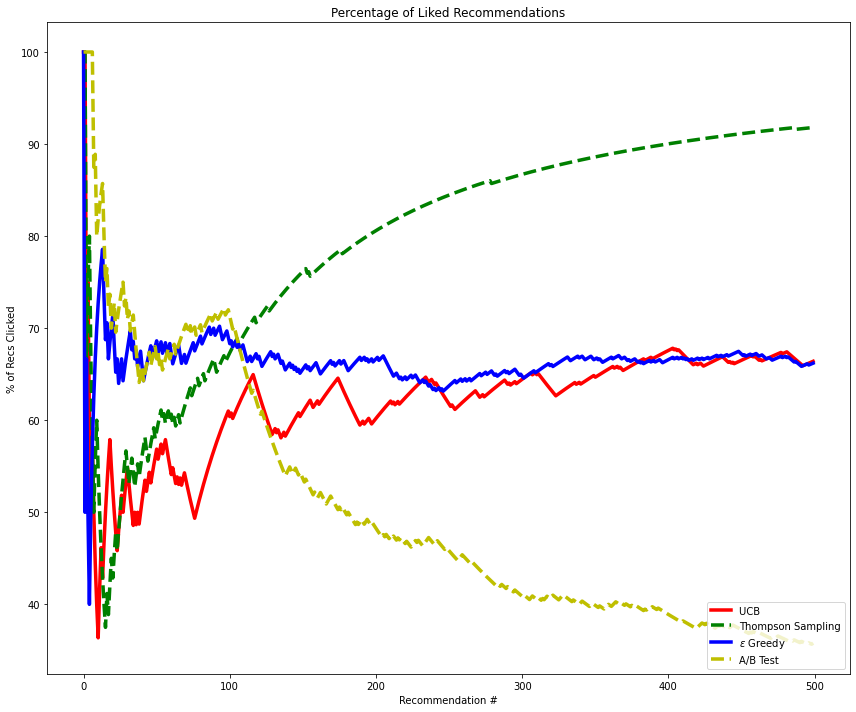

In [ ]:
ucb_results_df = pd.read_csv('ucb_results_df.csv').drop('Unnamed: 0', axis=1)
thompson_results_df = pd.read_csv('thompson_results_df.csv').drop('Unnamed: 0', axis=1)
epsilon_results_df = pd.read_csv('epsilon_results_df.csv').drop('Unnamed: 0', axis=1)
ab_results_df = pd.read_csv('ab_results_df.csv').drop('Unnamed: 0', axis=1)

#Grouping the each data frame with visit with mean
ucb_avg_results_df = ucb_results_df.groupby('visit', as_index=False).mean()
thompson_avg_results_df = thompson_results_df.groupby('visit', as_index=False).mean()
epsilon_avg_results_df = epsilon_results_df.groupby('visit', as_index=False).mean()
ab_avg_results_df = ab_results_df.groupby('visit', as_index=False).mean()

# using a color-blind friendly palette with 10 colors
color_blind_palette_10 = ['#cfcfcf', '#ffbc79', '#a2c8ec', '#898989', '#c85200',
                          '#5f9ed1', '#595959', '#ababab', '#ff800e', '#006ba4']

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,10))

for (avg_results_df, style) in [(ucb_avg_results_df, 'r-'),
                                (thompson_avg_results_df, 'g--'),
                                (epsilon_avg_results_df, 'b-'),
                                (ab_avg_results_df, 'y--')]:
    
    ax.plot(avg_results_df.visit, avg_results_df.fraction_relevant, style, linewidth=3.5)


ax.set_title('Percentage of Liked Recommendations')
ax.set_xlabel('Recommendation #')
ax.set_ylabel('% of Recs Clicked')

#ax.set_xticks(range(0,22000,5000))
#ax.set_ylim(0.2, 0.6)
#ax.set_yticks(np.arange(0.2, 0.7, 0.1))

#rescale the y-axis tick labels to show them as a percentage
ax.set_yticklabels((ax.get_yticks()*100).astype(int))

ax.legend(['UCB ',
           'Thompson Sampling',
           '$\epsilon$ Greedy',
           'A/B Test'
          ],
          loc='lower right'
         )

plt.tight_layout()
plt.show()

From the above it is clear that Thompson smapling of multi arm bandit outperforms A/B testing. In the lower samples the A/B test perform better than all other algorithim, but as in when the number samples increase the thompson sampling starts performing beter and better.

In [ ]:
#hide
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d -p recohut

Author: Sparsh A.

Last updated: 2021-12-26 05:02:48

recohut: 0.0.7

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.144+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

numpy     : 1.19.5
matplotlib: 3.2.2
IPython   : 5.5.0
pandas    : 1.1.5

